In [ ]:
!pip install numpy matplotlib pandas torch triton

In [ ]:
!pip install --upgrade torch

In [ ]:
!pip install --upgrade triton   

In [4]:
import torch
import triton
import triton.language as tl

In [5]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [15]:
@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
):  
    PID = tl.program_id(axis=0)
    block_start = PID * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    # load data from DRAM/HBM to SRAM
    x = tl.load(x_ptr + offsets, mask=mask, other=None) # shape (BLOCK_SIZE)
    y = tl.load(y_ptr + offsets, mask=mask, other=None) # shape (BLOCK_SIZE)
    output = x + y
    # write data back to DRAM/HBM
    tl.store(output_ptr + offsets, output, mask=mask)

In [16]:
def add(x, y):
    # pre-allocate output tensor
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE
    # defining the launch grid
    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    add_kernel[grid](
        x, 
        y,
        output,
        n_elements,
        BLOCK_SIZE=1024,
    )
    return output

In [17]:
def test_add_kernal(size, atol=1e-3, rtol=1e-3, device=DEVICE):
    torch.manual_seed(0)
    x = torch.randn(size, device=device)
    y = torch.randn(size, device=device)
    z = add(x, y)
    z_ref = x + y
    torch.testing.assert_close(z, z_ref, atol=atol, rtol=rtol)
    print("Test passed")

In [ ]:
test_add_kernal(4096)
test_add_kernal(4097)

In [21]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  
        x_vals=[2**i for i in range(10, 24, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'PyTorch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={}
    )
)

def benchmark(size, provider):
    torch.manual_seed(0)
    x = torch.randn(size, device=DEVICE, dtype=torch.float32)
    y = torch.randn(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.05, 0.95]

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    if provider == 'torch': 
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)    

    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

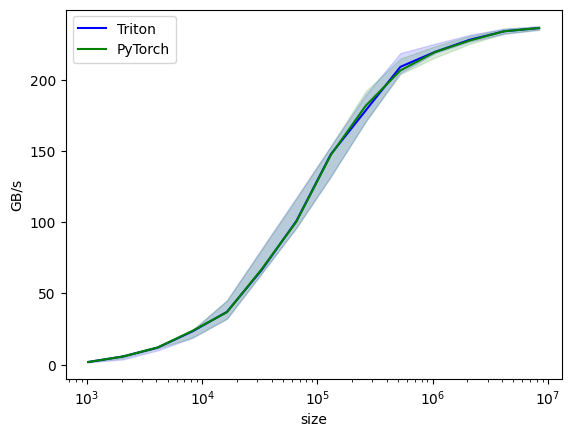

In [23]:
benchmark.run(show_plots=True)